# Create Graph from asy results

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML
from IPython.display import display
import os
import re
import glob
import fnmatch
from datetime import date, datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import timeit

from pandarallel import pandarallel
import argparse
import sys

In [2]:
import collections

import numpy as np
import pandas as pd
from pandas import *
from numpy import int64,float64

import os
import sys
import glob
import subprocess
import paramiko
import time
from datetime import datetime, timedelta, date

import seaborn as sns
import plotly 
import plotly.graph_objs as go
from IPython.display import HTML
import plotly.io as pio
pio.renderers.default='iframe'  # Dont forget: to use plotly MUST set
import plotly.express as px
import matplotlib.pyplot as plt


import re
import json
from pprint import pprint
import requests
import cfscrape
from lxml import etree
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize

# import pyspark
# from pyspark.sql.types import *
# import pyspark.sql.functions as F
# from pyspark.sql.functions import input_file_name, regexp_extract, split, col, lit, udf 
# import functools

# GLOBALS

In [3]:
RES="results/result_table_ases_up_and_open.csv"
CLASSIF='results/as_classification.csv'
IMG='/Users/bertholdo/PAPERS/asym/leandro/'

In [4]:
pd.set_option('display.max_rows', 20)

# FUNCTIONS

In [5]:
def result_view(tipo, netasn, pfxsize):
    '''return a dataframe with result_table view based on:
    tipo: asy,any,exc
    netasn: net, asn
    pfxsize: 24,23
    usage: result_view('asy','asn','24')
    NOte ASN will also return qt_onlydiscard() and qt_ans_nonetworks(not mapped AS on verfploter)
    '''
    

    # Read result_table just fist time
    global dfall
    if 'dfall' not in globals():
        print (f'Reading {RES}')
        dfall=pd.read_csv(RES)
        dfall['date'] = pd.to_datetime(dfall['date']).dt.date
        dfall=dfall.fillna(0)
    
    # select columns
    method = tipo+pfxsize
    df = dfall[dfall['method']==method]
    select=['_'+netasn, pfxsize]
    col=['ixp','date']
    col.extend([col for col in df.columns if all(x in col for x  in select) ])
    #col=[x for x in col if not x.startswith('qt_asn_nonetworks') and not x.startswith('qt_asn_onlydiscard')]
    col=[x for x in col]
    
    return df[col]

# MAIN

# Check samples

## By ASN-24

Reading results/result_table_ases_up_and_open.csv


<AxesSubplot:xlabel='date'>

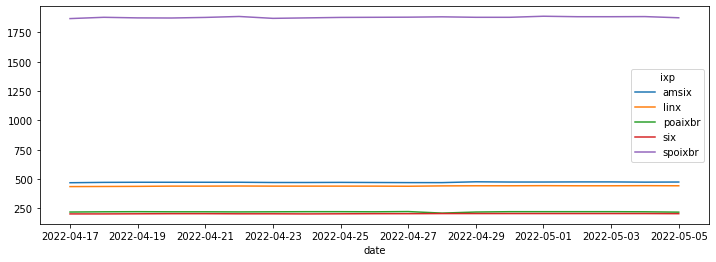

In [6]:
df=result_view('asy','asn','24')

df=df[['date', 'ixp', 'nei_asn24']]
data=df.pivot(index='date',columns='ixp')['nei_asn24']
data.plot(figsize=(12, 4))

## By NET-24

<AxesSubplot:xlabel='date'>

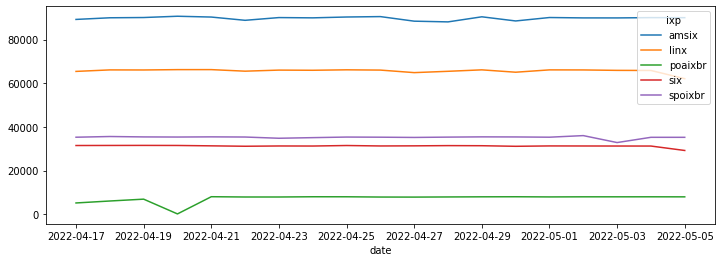

In [7]:
df=result_view('asy','net','24')

df=df[['date', 'ixp', 'nei_net24']]
data=df.pivot(index='date',columns='ixp')['nei_net24']
data.plot(figsize=(12, 4))

# Table of symmetry by ASN

# Full ixp symmetry (considering just one sample)

#### FULL NET

In [8]:
# Network asymmetry for all (not just neighbors) 
df=result_view('full','net','23')
df=df.loc[:, df.columns!='date']
df=df.groupby('ixp').agg('median') #agg(['mean','std'])
df=df.sort_values('ixp')
full23=df

pc=pd.DataFrame()
pc['sym23']  = round( df['qt_net_sym23']/df['nei_net23']*100 ,2)
pc['asy23-in'] = round( df['qt_net_asy23_in']/df['nei_net23']*100 ,2)
pc['asy23-out']= round( df['qt_net_asy23_out']/df['nei_net23']*100 ,2)
pfull23=pc

df=result_view('full','net','24')
df=df.loc[:, df.columns!='date']
df=df.groupby('ixp').agg('median') #agg(['mean','std'])
df=df.sort_values('ixp')
full24=df
pc=pd.DataFrame()
pc['sym24']  = round( df['qt_net_sym24']/df['nei_net24']*100 ,2)
pc['asy24-in'] = round( df['qt_net_asy24_in']/df['nei_net24']*100 ,2)
pc['asy24-out']= round( df['qt_net_asy24_out']/df['nei_net24']*100 ,2)
pfull24=pc

# join numbers and percentage
df=pfull23.join(pfull24).join(full23).join(full24)

# order columns
#df=df[['nei_net24',  'qt_net_sym24','sym24',  'qt_net_asy24_in','asy24-in',  'qt_net_asy24_out','asy24-out',
#       'nei_net23',  'qt_net_sym23','sym23',  'qt_net_asy23_in','asy23-in',  'qt_net_asy23_out','asy23-out' ]]
df=df[['nei_net24',  'sym24',  'asy24-in',  'asy24-out',
       'nei_net23',  'sym23',  'asy23-in',  'asy23-out' ]]



# rename for multiIndexing
col=dict({'nei_net24'		  :'24-nei-net',
         'nei_net23'		  :'23-nei-net', 
         'qt_net_sym24'	      :'24-nei-sym',
         'qt_net_sym23'	      :'23-nei-sym', 
         'qt_net_asy24_in'    :'24-only-in',
         'qt_net_asy23_in'    :'23-only-in', 
         'qt_net_asy24_out'   :'24-only-out',
         'qt_net_asy23_out'   :'23-only-out',
         'sym23'              :'23-perc-sym',
         'asy23-in'           :'23-perc-in',
         'asy23-out'          :'23-perc-out',
         'sym24'              :'24-perc-sym',
         'asy24-in'           :'24-perc-in',
         'asy24-out'          :'24-perc-out',          
         })
df=df.rename(columns=col).sort_index()

d=df.set_axis( df.columns.str.split('-',1,expand=True), axis='columns', inplace=False )#.swaplevel(0,1, axis='columns')#.reset_index()
d.stack(0).swaplevel(0,1, axis='rows').T


print( d.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         #{'selector': 'th', 'props':[('text-align', 'center')]}, # does not work
                        ], overwrite=False)
      .format(precision=1, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
      #.hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-net") 
     )

d.style\
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         {'selector': 'th', 'props':[('text-align', 'center')]},
                        ], overwrite=False)\
      .format(precision=2, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
      #.hide(axis='index')
      #.to_latex(position_float="centering", label="tab:percent-net") 

\begin{table}
\centering
\label{tab:percent-net}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{24} & \multicolumn{4}{r}{23} \\
 & nei-net & perc-sym & perc-in & perc-out & nei-net & perc-sym & perc-in & perc-out \\
ixp &  &  &  &  &  &  &  &  \\
\midrule
amsix & 795,584.0 & 55.2 & 22.4 & 22.4 & 658,425.0 & 41.4 & 18.3 & 40.3 \\
linx & 958,614.0 & 30.3 & 34.4 & 35.3 & 839,548.0 & 22.1 & 26.5 & 51.3 \\
poaixbr & 50,945.0 & 38.0 & 37.8 & 24.2 & 46,993.0 & 35.4 & 32.5 & 32.1 \\
\hline
\end{tabular}
\end{table}



#### FULL ASN

In [9]:
df=result_view('full','asn','23')

data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')
full23=data
pc=pd.DataFrame()
pc['sym23']  =   round( data['qt_asn_sym23']    / data['nei_asn23']*100 ,2)
pc['asy23-in'] = round( data['qt_asn_asy23_in'] / data['nei_asn23']*100 ,2)
pc['asy23-out']= round( data['qt_asn_asy23_out']/ data['nei_asn23']*100 ,2)
pc['hybrid23'] = round( data['qt_asn_hib23']    / data['nei_asn23']*100 ,2)
pc['unmapped23']=round( (data['qt_asn_onlydiscard23']+data['qt_asn_nonetworks23']) / data['nei_asn23']*100 ,2)
pfull23=pc
display(full23)

df=result_view('full','asn','24')
data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')
full24=data
pc=pd.DataFrame()
pc['sym24']  =   round( data['qt_asn_sym24']    / data['nei_asn24']*100 ,2)
pc['asy24-in'] = round( data['qt_asn_asy24_in'] / data['nei_asn24']*100 ,2)
pc['asy24-out']= round( data['qt_asn_asy24_out']/ data['nei_asn24']*100 ,2)
pc['hybrid24'] = round( data['qt_asn_hib24']    / data['nei_asn24']*100 ,2)
pc['unmapped24']=round( (data['qt_asn_onlydiscard24']+data['qt_asn_nonetworks24']) / data['nei_asn24']*100 ,2)

pfull24=pc
display(pfull24)
display(pfull24.sum(axis=1))


,nei_asn23,qt_asn_sym23,qt_asn_asy23_in,qt_asn_asy23_out,qt_asn_hib23,qt_asn_onlydiscard23,qt_asn_nonetworks23
ixp,,,,,,,
amsix,57480.0,12568.0,5079.0,14121.0,518.0,25194.0,0.0
linx,57397.0,8589.0,5563.0,14641.0,483.0,28121.0,0.0
poaixbr,57394.0,2179.0,633.0,2789.0,46.0,51747.0,0.0


,sym24,asy24-in,asy24-out,hybrid24,unmapped24
ixp,,,,,
amsix,30.89,12.73,15.20,0.92,40.26
linx,24.50,15.21,15.65,0.89,43.74
poaixbr,4.88,1.88,3.73,0.09,89.42


ixp
amsix      100.00
linx        99.99
poaixbr    100.00
dtype: float64

### ASY_ASN_24

In [10]:
df=result_view('asy','asn','24')

data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')

pc=pd.DataFrame()
pc['sym24']  = round( data['qt_asn_sym24']/data['nei_asn24']*100 ,2)
pc['asy_in'] = round( data['qt_asn_asy24_in']/data['nei_asn24']*100 ,2)
pc['asy_out']= round( data['qt_asn_asy24_out']/data['nei_asn24']*100 ,2)
pc['hybrid'] = round( data['qt_asn_hib24']/data['nei_asn24']*100 ,2)
pc['unmapped']=round( (data['qt_asn_onlydiscard24']+data['qt_asn_nonetworks24']) / data['nei_asn24']*100 ,2)


asn24=pc
pc

,sym24,asy_in,asy_out,hybrid,unmapped
ixp,,,,,
amsix,80.93,4.24,6.36,2.54,5.93
linx,77.68,5.01,7.97,2.28,7.29
poaixbr,86.36,1.36,3.18,0.91,8.18
six,66.18,5.88,12.75,4.41,10.78
spoixbr,78.13,1.06,6.17,0.69,13.89


### ASY_ASN_23

In [11]:
df=result_view('asy','asn','23')

data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')

pc=pd.DataFrame()
pc['sym23']  = round( data['qt_asn_sym23']/data['nei_asn23']*100 ,2)
pc['asy_in'] = round( data['qt_asn_asy23_in']/data['nei_asn23']*100 ,2)
pc['asy_out']= round( data['qt_asn_asy23_out']/data['nei_asn23']*100 ,2)
pc['hybrid'] = round( data['qt_asn_hib23']/data['nei_asn23']*100 ,2)
pc['unmapped']=round( (data['qt_asn_onlydiscard23']+data['qt_asn_nonetworks23']) / data['nei_asn23']*100 ,2)


asn23=pc
pc

,sym23,asy_in,asy_out,hybrid,unmapped
ixp,,,,,
amsix,59.96,3.39,27.97,2.75,6.14
linx,63.55,3.19,22.78,2.73,7.74
poaixbr,83.18,0.91,6.36,0.91,8.18
six,59.80,5.39,19.61,4.41,10.78
spoixbr,75.36,0.90,9.37,0.80,13.78


# Table of Symmetry by net 

## EXC_NET-24

In [12]:
df=result_view('exc','net','24')
df=df.loc[:, df.columns!='date']
#print (df.columns)
data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')
pc=pd.DataFrame()
pc['sym24']    = round( data['qt_net_sym24']/data['nei_net24']*100 ,2)
pc['asy24-in'] = round( data['qt_net_asy24_in']/data['nei_net24']*100 ,2)
pc['asy24-out']= round( data['qt_net_asy24_out']/data['nei_net24']*100 ,2)

excnet24  = data
pexcnet24 = pc

pexcnet24
excnet24.style.format(precision=2, thousands=",")

,nei_net24,qt_net_sym24,qt_net_asy24_in,qt_net_asy24_out
ixp,,,,
amsix,"77,661.00","71,680.00","5,961.00",0.00
linx,"63,333.00","58,748.00","4,642.00",0.00
poaixbr,"6,329.00","6,246.00",84.00,0.00
six,"28,840.00","27,644.00","1,156.00",0.00
spoixbr,"31,089.00","30,441.00",611.00,0.00


# ASY_24_NET

In [13]:
df=result_view('asy','net','24')
df=df.loc[:, df.columns!='date']
data=df.groupby('ixp').agg('median') 

In [14]:
data=data.sort_values('ixp')
pc=pd.DataFrame()
pc['sym24']    = round( data['qt_net_sym24']/data['nei_net24']*100,2)
pc['asy24-in'] = round( data['qt_net_asy24_in']/data['nei_net24']*100,2)
pc['asy24-out']= round( data['qt_net_asy24_out']/data['nei_net24']*100,2)

net24  = data
pnet24 = pc

pnet24
#net24.style.format(precision=2, thousands=",")

,sym24,asy24-in,asy24-out
ixp,,,
amsix,79.42,6.63,13.83
linx,88.46,7.02,4.17
poaixbr,78.93,1.06,20.02
six,88.17,3.69,8.06
spoixbr,85.36,1.72,12.27


### ASY_NET_24 BOXPLOT
<pre>
{fig:'leandro/symmetry_subnets24_box_plot.pdf'}
</pre>

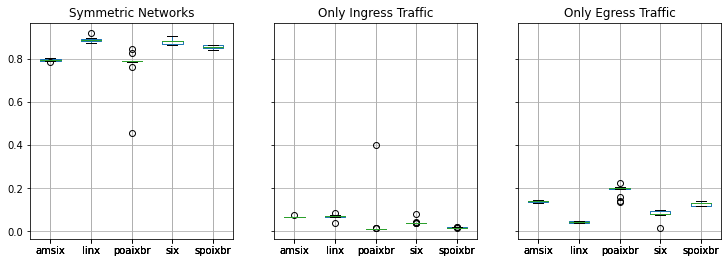

In [15]:
df=result_view('asy','net','24')
df['sym']=     df['qt_net_sym24']/df['nei_net24']
df['only_in']= df['qt_net_asy24_in']/df['nei_net24']
df['only_out']=df['qt_net_asy24_out']/df['nei_net24']


df=df[['ixp','date','sym','only_in','only_out']]
asy24=df.copy()

pd.options.plotting.backend = 'matplotlib'
ax=df.boxplot(column=['sym','only_in','only_out'],by='ixp', figsize=(12,4), layout=(1,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1,2:
    ax[x].set_xlabel('')
#Add title to graph
ax[0].set_title('Symmetric Networks')
ax[1].set_title('Only Ingress Traffic')
ax[2].set_title('Only Egress Traffic')
#ax[0].set_ylabel('Percentage of Networks')

plt.savefig(IMG+'boxplot_asy_24_net.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()


## ASY-NET-23 boxplot

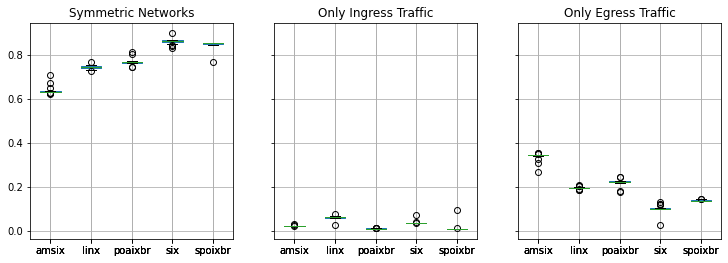

In [16]:
# SYM-23 
df=result_view('asy','net','23')
df['sym']=     df['qt_net_sym23']/df['nei_net23']
df['only_in']= df['qt_net_asy23_in']/df['nei_net23']
df['only_out']=df['qt_net_asy23_out']/df['nei_net23']

df=df[['ixp','date','sym','only_in','only_out']]
asy23 = df.copy()

pd.options.plotting.backend = 'matplotlib'
ax=df.boxplot(column=['sym','only_in','only_out'],by='ixp', figsize=(12,4), layout=(1,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1,2:
    ax[x].set_xlabel('')
#Add title to graph
ax[0].set_title('Symmetric Networks')
ax[1].set_title('Only Ingress Traffic')
ax[2].set_title('Only Egress Traffic')
#ax[0].set_ylabel('Percentage of Networks')

plt.savefig(IMG+'boxplot_asy_23_net.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

## ANY-23 

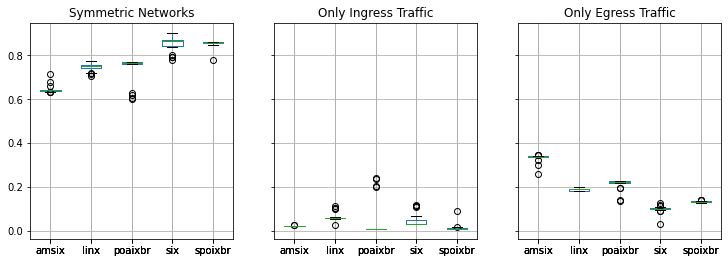

In [17]:
# ANY-23 
df=result_view('any','net','23')
df['sym']=     df['qt_net_sym23']/df['nei_net23']
df['only_in']= df['qt_net_asy23_in']/df['nei_net23']
df['only_out']=df['qt_net_asy23_out']/df['nei_net23']

df=df[['ixp','date','sym','only_in','only_out']]
any23 = df.copy()

pd.options.plotting.backend = 'matplotlib'
ax=df.boxplot(column=['sym','only_in','only_out'],by='ixp', figsize=(12,4), layout=(1,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1,2:
    ax[x].set_xlabel('')
#Add title to graph
ax[0].set_title('Symmetric Networks')
ax[1].set_title('Only Ingress Traffic')
ax[2].set_title('Only Egress Traffic')
#ax[0].set_ylabel('Percentage of Networks')

plt.savefig(IMG+'boxplot_any_23_net.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

## ANY-24

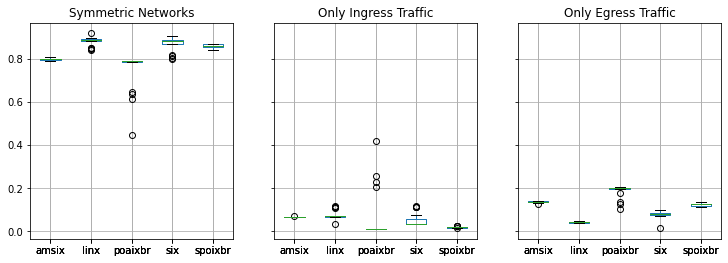

,ixp,date,sym,only_in,only_out
1,amsix,2022-05-05,0.797624,0.064597,0.137779
7,linx,2022-05-05,0.921408,0.035778,0.042813
13,poaixbr,2022-05-05,0.790142,0.010562,0.199296


In [18]:
df=result_view('any','net','24')
df['sym']=     df['qt_net_sym24']/df['nei_net24']
df['only_in']= df['qt_net_asy24_in']/df['nei_net24']
df['only_out']=df['qt_net_asy24_out']/df['nei_net24']


df=df[['ixp','date','sym','only_in','only_out']]
pd.options.plotting.backend = 'matplotlib'
ax=df.boxplot(column=['sym','only_in','only_out'],by='ixp', figsize=(12,4), layout=(1,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1,2:
    ax[x].set_xlabel('')
#Add title to graph
ax[0].set_title('Symmetric Networks')
ax[1].set_title('Only Ingress Traffic')
ax[2].set_title('Only Egress Traffic')
#ax[0].set_ylabel('Percentage of Networks')

plt.savefig(IMG+'boxplot_any_24_net.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()
display(df.head(3))

## ASY_NET_23

In [19]:
df=result_view('asy','net','23')
#print (df.columns)
data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')

pc=pd.DataFrame()
pc['sym23']    = round( data['qt_net_sym23']/data['nei_net23']*100,2) 
pc['asy23-in'] = round( data['qt_net_asy23_in']/data['nei_net23'] *100,2) 
pc['asy23-out']= round( data['qt_net_asy23_out']/data['nei_net23'] *100,2) 

net23  = data
pnet23 = pc

pnet23
#net23.style.format(precision=2, thousands=",")

,sym23,asy23-in,asy23-out
ixp,,,
amsix,63.25,2.17,34.49
linx,74.34,6.05,19.33
poaixbr,76.71,0.96,22.24
six,86.36,3.44,10.13
spoixbr,85.45,0.84,13.65


# PAPER boxplot:: Refining anycast (plot 18Apr-20Apr)
<pre>
    {fig:boxplot-anycast}
    {fig:violin-anycast}
    {fig:linx-anycast-week}
</pre>

## Anycast by day (all period): Here we notice the effect on pinger place on anycast/only-ingress 
(IXP peers view)

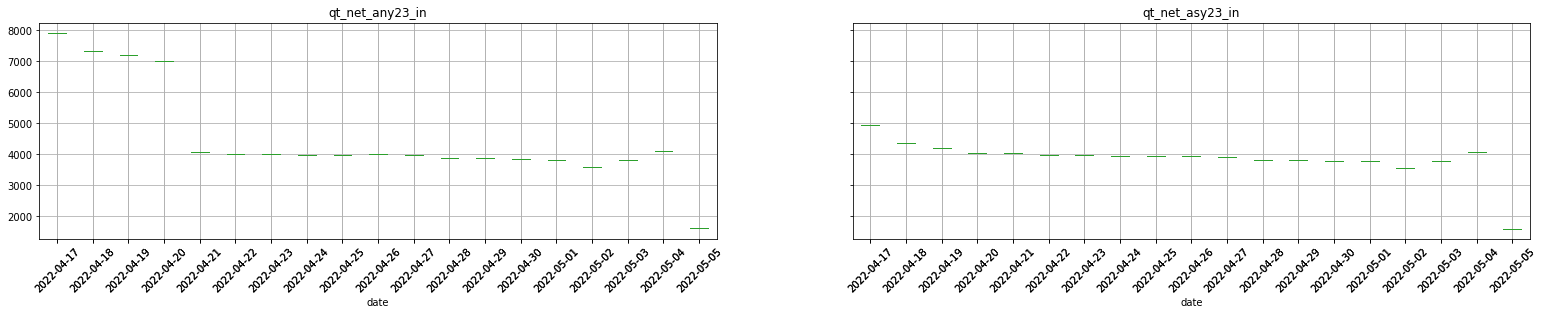

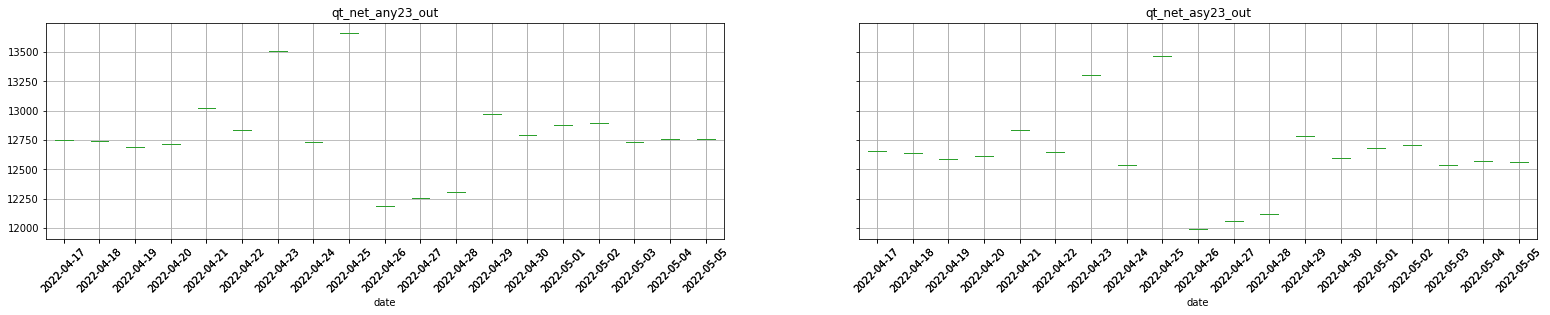

In [20]:
# Anycast networks included (/23)
d1=result_view('any','net','23')
d1=d1.rename(columns={'qt_net_asy23_in':'qt_net_any23_in', 'qt_net_asy23_out':'qt_net_any23_out'})
# Excluded anycast networks
d2=result_view('asy','net','23')

# # Anycast networks included (/24)
# d1=result_view('any','net','24')
# d1=d1.rename(columns={'qt_net_asy24_in':'qt_net_any24_in', 'qt_net_asy24_out':'qt_net_any24_out'})
# # Excluded anycast networks
# d2=result_view('asy','net','24')

# join datataframes
d1=d1.set_index(['ixp','date'])
d2=d2.set_index(['ixp','date'])
df=pd.concat([d1,d2], axis=1)
df=df.reset_index()


# Plot anycast variation by day for one IXP (/23)
df=df[df['ixp']=='linx']
df.boxplot(column=['qt_net_any23_in','qt_net_asy23_in'],by='date', figsize=(40,4), layout=(1,3), rot=45)
plt.suptitle('')
df.boxplot(column=['qt_net_any23_out','qt_net_asy23_out'],by='date', figsize=(40,4), layout=(1,3), rot=45)
plt.suptitle('')


# #Plot anycast variation by day for one IXP (/24)
# df=df[df['ixp']=='linx']
# df.boxplot(column=['qt_net_any24_in','qt_net_asy24_in'],by='date', figsize=(40,4), layout=(1,3), rot=45)
# plt.suptitle('')
# df.boxplot(column=['qt_net_any24_out','qt_net_asy24_out'],by='date', figsize=(40,4), layout=(1,3), rot=45)
# plt.suptitle('')

plt.savefig(IMG+'linx-anycast-week.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

### All IXPs boxplot mixing methods(17-20 pinger in ixp, 21-5May pinger on MIA)

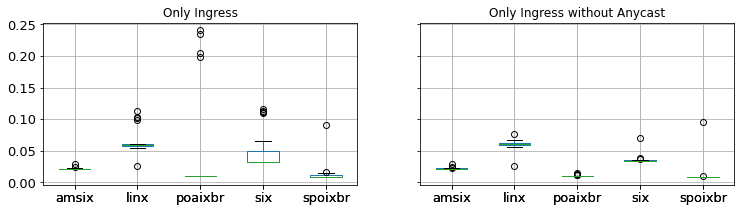

In [29]:
d1=any23[['ixp','date','only_in']].copy()
d1=d1.rename(columns={'only_in':'Only Ingress'})
d1=d1.set_index(['ixp','date'])

d2=asy23[['ixp','date','only_in']].copy()
d2=d2.rename(columns={'only_in':'Only Ingress without Anycast'})
d2=d2.set_index(['ixp','date'])

df=pd.concat([d1,d2], axis=1)
df=df.reset_index()

ax=df.boxplot(column=['Only Ingress','Only Ingress without Anycast'],by='ixp', figsize=(12,3), layout=(1,2), fontsize=13)
#ax.set_xticklabels(Fontsize=12)

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1:
    ax[x].set_xlabel('')
#Add title to graph
#ax[0].set_title('Only Ingress ')
#ax[1].set_title('Only Ingress without Anycast')

plt.savefig(IMG+'boxplot_anycast_halfsize.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

In [27]:
df

,ixp,date,Only Ingress,Only Ingress without Anycast
0,amsix,2022-05-05,0.021156,0.021695
1,linx,2022-05-05,0.025453,0.025836
2,poaixbr,2022-05-05,0.009572,0.009575
3,six,2022-05-05,0.065914,0.070173
4,spoixbr,2022-05-05,0.008309,0.008166
...,...,...,...,...
90,amsix,2022-04-17,0.028536,0.028819
91,linx,2022-04-17,0.112877,0.076223
92,poaixbr,2022-04-17,0.240723,0.014410
93,six,2022-04-17,0.115341,0.038875


## Anycast Analysis (17-20Apr) 

In [ ]:
# Anycast networks included (/23)
d1=result_view('any','net','23')
d1=d1.rename(columns={'qt_net_asy23_in':'qt_net_any23_in', 'qt_net_asy23_out':'qt_net_any23_out'})
# Excluded anycast networks
d2=result_view('asy','net','23')

# # Anycast networks included (/24)
# d1=result_view('any','net','24')
# d1=d1.rename(columns={'qt_net_asy24_in':'qt_net_any24_in', 'qt_net_asy24_out':'qt_net_any24_out'})
# # Excluded anycast networks
# d2=result_view('asy','net','24')

# Select dates (17-20 pinger on-site)
start_day=datetime.strptime('2022-04-17', "%Y-%m-%d").date()
end_day=datetime.strptime('2022-04-20', "%Y-%m-%d").date()

#end_day=datetime.strptime('2022-05-05', "%Y-%m-%d").date()
#start_day=datetime.strptime('2022-04-21', "%Y-%m-%d").date()

d1 = d1[ (d1['date']>=start_day) & (d1['date']<=end_day) ]
d2 = d2[ (d2['date']>=start_day) & (d2['date']<=end_day) ]

# join datataframes
d1=d1.set_index(['ixp','date'])
d2=d2.set_index(['ixp','date'])
df=pd.concat([d1,d2], axis=1)
df=df.reset_index()

### Violin

In [ ]:
plt.figure(figsize=(12,4))
#plt.figure(figsize=(20,10))


plt.subplot(1, 2, 1) #index 1
ax1=sns.violinplot(x='ixp', y='qt_net_any23_in', data=d1.reset_index())
ax1=sns.swarmplot(x='ixp',y='qt_net_any23_in', data=d1.reset_index(),  alpha=0.5)
ax1.set_title('Only Ingress')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Networks')
ax1.set(ylim=(0, 9000))

plt.subplot(1, 2, 2) # index 2
ax2=sns.violinplot(x='ixp', y='qt_net_asy23_in', data=d2.reset_index())
ax2=sns.swarmplot(x='ixp',y='qt_net_asy23_in', data=d2.reset_index(),  alpha=0.5)
ax2.set_title('Only Ingress without Anycast')
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.axes.get_yaxis().set_visible(False)
ax2.set(ylim=(0, 9000))

plt.savefig(IMG+'violin_anycast.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

### Boxplot

In [ ]:
#df=df['ixp', 'date', 'nei_net23', 'qt_net_sym23', 'qt_net_any23_in',
#       'qt_net_any23_out', 'nei_net23', 'qt_net_sym23', 'qt_net_asy23_in',
#       'qt_net_asy23_out']
#ax=df.boxplot(column=['Only Ingress','Only Ingress without Anycast'],by='ixp', figsize=(12,4), layout=(1,3))
ax=df.boxplot(column=['qt_net_any23_in','qt_net_asy23_in'],by='ixp', figsize=(12,4), layout=(1,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
for x in 0,1:
    ax[x].set_xlabel('')
#Add title to graph
ax[0].set_title('Only Ingress ')
ax[1].set_title('Only Ingress without Anycast')

plt.savefig(IMG+'boxplot_anycast.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()


#df.boxplot(column=['qt_net_any23_in','qt_net_asy23_in'],by='ixp', figsize=(12,4), layout=(1,3))


### Anycast only egress comparison (not afected by anycast)

In [ ]:
plt.figure(figsize=(20,10))
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)

ax1=sns.violinplot(x='ixp', y='qt_net_any23_out', data=d1.reset_index())
ax1=sns.swarmplot(x='ixp',y='qt_net_any23_out', data=d1.reset_index(),  alpha=0.5)
#ax1.set(ylim=(10, 40))

plt.subplot(1, 2, 2) # index 2
ax2=sns.violinplot(x='ixp', y='qt_net_asy23_out', data=d2.reset_index())
ax2=sns.swarmplot(x='ixp',y='qt_net_asy23_out', data=d2.reset_index(),  alpha=0.5)
#ax2.set(ylim=(10, 5000))

plt.show()

# PAPER boxplot:: Comparing /24 and /23 
<pre>
    {fig:boxplot-prefixsize}
</pre>

In [ ]:
d1=asy23
d1=d1.rename(columns={'only_in':'Only Ingress', 'only_out':'Only Egress', 'sym':'Symmetric'})
d1=d1.set_index(['ixp','date'])

d2=asy24
d2=d2.rename(columns={'only_in':'Only Ingress(24)', 'only_out':'Only Egress(24)', 'sym':'Symmetric(24)'})
d2=d2.set_index(['ixp','date'])

df=pd.concat([d1,d2], axis=1)
df=df.reset_index()


In [ ]:

# plot 2x3
ax=df.boxplot(column=['Symmetric', 'Only Ingress', 'Only Egress','Symmetric(24)', 'Only Ingress(24)', 'Only Egress(24)'],
              by='ixp', figsize=(12,8), layout=(2,3))

# hit auto suptitle
plt.suptitle('')
# remove automatic label
#for x in range(6):
#    ax[x].set_xlabel('')
#Add title to graph
#ax[0].set_title('Symmetric Networks')
#ax[1].set_title('Only Ingress Traffic')
#ax[2].set_title('Only Egress Traffic')
#ax[0].set_ylabel('Percentage of Networks')

plt.savefig(IMG+'boxplot_prefixsize.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1) # index 1
ax1=sns.violinplot(x='ixp', y='Symmetric', data=df.reset_index())
ax1.set(ylim=(0, 1))
ax1.set_ylabel('Networks')
ax1.set_title('Symmetry')
ax1.xaxis.set_visible(False)

plt.subplot(2, 3, 2) # index 2
ax2=sns.violinplot(x='ixp', y='Only Egress', data=df.reset_index())
ax2.set(ylim=(0, 1))
ax2.set_ylabel('')
ax2.set_title('Only Egress')
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

plt.subplot(2, 3, 3)
ax3=sns.violinplot(x='ixp', y='Only Ingress', data=df.reset_index())
ax3.set(ylim=(0, 1))
ax3.set_ylabel('')
ax3.set_title('Only Ingress')
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title('Only Egress')


plt.subplot(2, 3, 4)
ax4=sns.violinplot(x='ixp', y='Symmetric(24)', data=df.reset_index())
ax4.set(ylim=(0, 1))
ax4.set_title('Symmetric(24)')


plt.subplot(2, 3, 5)
ax5=sns.violinplot(x='ixp', y='Only Egress(24)', data=df.reset_index())
ax5.set(ylim=(0, 1))
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.yaxis.set_visible(False)
ax5.set_title('Only Egress(24)')


plt.subplot(2, 3, 6)
ax6=sns.violinplot(x='ixp', y='Only Ingress(24)', data=df.reset_index())
ax6.set(ylim=(0, 1))
ax6.set_ylabel('')
ax6.set_xlabel('')
ax6.yaxis.set_visible(False)
ax6.set_title('Only Ingress(24)')

plt.savefig(IMG+'violin_prefixsize.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
print(df.groupby('ixp').mean().to_latex())

# PAPER Table::: NETWORK SYMMETRY
<pre>
{tab:percent-net24} AND 
{tab:percent-net24}
</pre>

In [ ]:
# Rename columns
col=dict({'nei_net24'		  :'Neig. Net.',
         'nei_net23'		  :'Neig. Net.', 
         'sym24'              :'Symmetric',
         'sym23'              :'Symmetric',
         'asy24-in'           :'Only Ingress',
         'asy23-in'           :'Only Ingress',
         'asy24-out'          :'Only Egress',          
         'asy23-out'          :'Only Egress',
         })

#less specific prefix results
df=pnet23.join(net23)
df=df[['nei_net23',  'sym23',  'asy23-in',  'asy23-out' ]]
df=df.rename(columns=col).sort_index()
df23=df.reset_index()

#more specific prefix results
df=pnet24.join(net24)
df=df[['nei_net24',  'sym24',  'asy24-in',  'asy24-out' ]]
df=df.rename(columns=col).sort_index()
df24=df.reset_index()


# generate tables 
print(df24.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                        ], overwrite=False)
      .format({'Neig. Net.':'{0:,}', 'Symmetric':'{0:.2f}\%', 'Only Ingress':'{0:.2f}\%', 'Only Egress':'{0:.2f}\%'})
      .hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-net24", caption="Network symmetry using more specific prefix") 
     )

print(df23.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         #{'selector': 'th', 'props':[('text-align', 'center')]}, # does not work
                        ], overwrite=False)
      .format({'Neig. Net.':'{0:,}', 'Symmetric':'{0:.2f}\%', 'Only Ingress':'{0:.2f}\%', 'Only Egress':'{0:.2f}\%'})
      .hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-net23", caption="Network symmetry using same size prefix") 
     )
df24

In [ ]:
# mean of 
((net24['nei_net24']-net23['nei_net23'])/net23['nei_net23']).mean()

# PAPER Table::: ASN SYMMETRY
<pre>
{tab:percent-asn24} AND 
{tab:percent-asn23}
</pre>

### ASY_ASN_24

In [ ]:
df=result_view('asy','asn','24')
df=df.loc[:, df.columns!='date']
data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')
pc=pd.DataFrame()

# regular symmetry (will match 100% on rows)
pc['reg-sym24']    = round( data['qt_asn_sym24']/data['nei_asn24']*100,1)
# equalized symmetry (discounting Unkown networks)
pc['eq-sym24']    = round( data['qt_asn_sym24']/(data['nei_asn24']-(data['qt_asn_onlydiscard24']+data['qt_asn_nonetworks24']))*100,1)

pc['hyb24']    = round( data['qt_asn_hib24']/data['nei_asn24']*100,1)
pc['asy24-in'] = round( data['qt_asn_asy24_in']/data['nei_asn24']*100,1)
pc['asy24-out']= round( data['qt_asn_asy24_out']/data['nei_asn24']*100,1)
pc['hyb24']    = round( data['qt_asn_hib24']/data['nei_asn24']*100,1)
pc['qt-hyb24'] = round( data['qt_asn_hib24'],1)

pc['unmap24']  = round( (data['qt_asn_onlydiscard24']+data['qt_asn_nonetworks24'])/data['nei_asn24']*100,1)
pc['qt-unmap24']  = round( (data['qt_asn_onlydiscard24']+data['qt_asn_nonetworks24']),1)

asn24  = data
pasn24 = pc

pasn24


In [ ]:
data

### ASY_ASN_23

In [ ]:
df=result_view('asy','asn','23')
df=df.loc[:, df.columns!='date']
data=df.groupby('ixp').agg('median') #agg(['mean','std'])
data=data.sort_values('ixp')
pc=pd.DataFrame()
# regular symmetry (will match 100% on rows)
pc['reg-sym23']    = round( data['qt_asn_sym23']/data['nei_asn23']*100,1)
# equalized symmetry (discounting Unkown networks)
pc['eq-sym23'] = round( data['qt_asn_sym23']/(data['nei_asn23']-(data['qt_asn_onlydiscard23']+data['qt_asn_nonetworks23']))*100,1)
pc['asy23-in'] = round( data['qt_asn_asy23_in']/data['nei_asn23']*100,1)
pc['asy23-out']= round( data['qt_asn_asy23_out']/data['nei_asn23']*100,1)
pc['hyb23']    = round( data['qt_asn_hib23']/data['nei_asn23']*100,1)
pc['unmap23']  = round( (data['qt_asn_onlydiscard23']+data['qt_asn_nonetworks23'])/data['nei_asn23']*100,1)

asn23  = data
pasn23 = pc
pc

In [ ]:
# Rename columns
col=dict({'nei_asn24'		   :'ASes',
          'nei_asn23'		   :'ASes', 
          'eq-sym24'              :'Symm',
          'eq-sym23'              :'Symm',
          'asy24-in'           :'Only IN',
          'asy23-in'           :'Only IN',
          'asy24-out'          :'Only EGRS',          
          'asy23-out'          :'Only EGRS',
          'hyb24'              :'Hybrid',          
          'hyb23'              :'Hybrid',  
          'qt_asn_asy24_in'    :'Ingress',
          'qt_asn_asy23_in'    :'Ingress',
          'qt_asn_asy24_out'   :'Egress',
          'qt_asn_asy23_out'   :'Egress',
          'unmap23'           :'Unk',
          'unmap24'           :'Unk',
         })

#less specific prefix results
df=pasn23.join(asn23)
df

In [ ]:
#df=df[['nei_asn23',  'sym23', 'hyb23',  'asy23-in', 'qt_asn_asy23_in',  'asy23-out', 'qt_asn_asy23_out' ]]
df=df[['nei_asn23', 'unmap23', 'eq-sym23', 'hyb23',  'qt_asn_asy23_in', 'qt_asn_asy23_out' ]]

df=df.rename(columns=col).sort_index()
df23=df.reset_index()

#more specific prefix results
df=pasn24.join(asn24)
#df=df[['nei_asn24',  'sym24', 'hyb24',  'asy24-in', 'qt_asn_asy24_in',  'asy24-out', 'qt_asn_asy24_out' ]]
df=df[['nei_asn24', 'unmap24', 'sym24', 'hyb24',  'qt_asn_asy24_in',  'qt_asn_asy24_out' ]]

df=df.rename(columns=col).sort_index()
df24=df.reset_index()

df

In [ ]:
# generate tables 
print(df24.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                        ], overwrite=False)
      .format({'ASes':'{0:,.0f}', 'Unk':'{0:.1f}\%', 'Symm':'{0:.1f}\%', 'Hybrid':'{0:.1f}\%', 
               'Only IN':'{0:.2f}\%',   'Ingress':'{0:,.0f}',
               'Only EGRS':'{0:.2f}\%', 'Egress':'{0:,.0f}',})
      .hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-asn24", caption="ASes symmetry using more specific prefix") 
     )

print(df23.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         #{'selector': 'th', 'props':[('text-align', 'center')]}, # does not work
                        ], overwrite=False)
      .format({'ASes':'{0:,.0f}', 'Unk':'{0:.1f}\%', 'Symm':'{0:.1f}\%', 'Hybrid':'{0:.1f}\%', 
               'Only IN':'{0:.2f}\%',   'Ingress':'{0:,.0f}',
               'Only EGRS':'{0:.2f}\%', 'Egress':'{0:,.0f}',})
      .hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-asn23", caption="ASes symmetry using same size prefix") 
     )
df24

# Networks table total numbers

In [ ]:
df=net23.join(net24)
df=df[['nei_net24','nei_net23', 'qt_net_sym24','qt_net_sym23', 'qt_net_asy24_in','qt_net_asy23_in', 'qt_net_asy24_out','qt_net_asy23_out',]]
#      'sym23','asy23-in','asy23-out' ,'sym24','asy24-in','asy24-out' ]]
col=dict({'nei_net24'		  :'24-nei-net',
         'nei_net23'		  :'23-nei-net', 
         'qt_net_sym24'	      :'24-nei-sym',
         'qt_net_sym23'	      :'23-nei-sym', 
         'qt_net_asy24_in'    :'24-only-in',
         'qt_net_asy23_in'    :'23-only-in', 
         'qt_net_asy24_out'   :'24-only-out',
         'qt_net_asy23_out'   :'23-only-out',
         'sym23'              :'23-perc-sym',
         'asy23-in'           :'23-perc-in',
         'asy23-out'          :'23-perc-out',
         'sym24'              :'24-perc-sym',
         'asy24-in'           :'24-perc-in',
         'asy24-out'          :'24-perc-out',          
         })
df=df.rename(columns=col)

d=df.set_axis( df.columns.str.split('-',1,expand=True), axis='columns', inplace=False ).swaplevel(0,1, axis='columns').reset_index()
print( d.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                        ], overwrite=False)
      .format(precision=1, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
      .hide(axis='index')
      .to_latex(position_float="centering", label="tab:netasy") 
     )
d

## ALL INFO IN ONE TABLE {tab:percent-net}

In [ ]:
# join numbers and percentage
df=pnet23.join(pnet24).join(net23).join(net24)

# order columns
#df=df[['nei_net24',  'qt_net_sym24','sym24',  'qt_net_asy24_in','asy24-in',  'qt_net_asy24_out','asy24-out',
#       'nei_net23',  'qt_net_sym23','sym23',  'qt_net_asy23_in','asy23-in',  'qt_net_asy23_out','asy23-out' ]]
df=df[['nei_net24',  'sym24',  'asy24-in',  'asy24-out',
       'nei_net23',  'sym23',  'asy23-in',  'asy23-out' ]]



# rename for multiIndexing
col=dict({'nei_net24'		  :'24-nei-net',
         'nei_net23'		  :'23-nei-net', 
         'qt_net_sym24'	      :'24-nei-sym',
         'qt_net_sym23'	      :'23-nei-sym', 
         'qt_net_asy24_in'    :'24-only-in',
         'qt_net_asy23_in'    :'23-only-in', 
         'qt_net_asy24_out'   :'24-only-out',
         'qt_net_asy23_out'   :'23-only-out',
         'sym23'              :'23-perc-sym',
         'asy23-in'           :'23-perc-in',
         'asy23-out'          :'23-perc-out',
         'sym24'              :'24-perc-sym',
         'asy24-in'           :'24-perc-in',
         'asy24-out'          :'24-perc-out',          
         })
df=df.rename(columns=col).sort_index()
df

d=df.set_axis( df.columns.str.split('-',1,expand=True), axis='columns', inplace=False )#.swaplevel(0,1, axis='columns')#.reset_index()
d

d.stack(0).swaplevel(0,1, axis='rows').T



print(d.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         #{'selector': 'th', 'props':[('text-align', 'center')]}, # does not work
                        ], overwrite=False)
      .format(precision=1, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
      #.hide(axis='index')
      .to_latex(position_float="centering", label="tab:percent-net") 
     )

d.style\
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                         {'selector': 'th', 'props':[('text-align', 'center')]},
                        ], overwrite=False)\
      .format(precision=2, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
      #.hide(axis='index')
      #.to_latex(position_float="centering", label="tab:percent-net") 

# TEST AREA

In [ ]:
df23

In [ ]:
df24

In [ ]:
df24.set_index('ixp').subtract(df23.set_index('ixp'))

In [ ]:
df24

In [ ]:
df23

In [ ]:
df24.set_index('ixp').subtract(df23.set_index('ixp'))

In [ ]:
df24.set_index('ixp').subtract(df23.set_index('ixp'))

In [ ]:
# # egress only ixsp
# df=pd.read_csv('/Users/bertholdo/Downloads/sp_116egress_networks.csv', dtype=str)
# len(df[['name_asn']].drop_duplicates()['name_asn'].to_list())
# df=df[['AS', 'type', 'name_asn' ]].drop_duplicates()